# Generative Tasks with Continuous Normalizing Flows and Flow Matching
Dingyan Zhong (Hacker)

This implementation is based on \
  • Flow Matching for Generative Modelling, Lipman et al., ICLR 2023 \
  • Neural Ordinary Differential Equations, Chen et al., NeurIPS 2018

## Continuous Normalizing Flows

Variables: Data points $x \in R^d$, Time $t\in [0,1]$\
Functions: Time-dependent probability density $p: [0,1]\times R^d → R$ \
Time-dependent vector field $v_t$ and a flow $\phi_t$ such that
$$\begin{align}
      \frac{\partial}{\partial t}\phi_t &= v_t(\phi_t)\\
      \phi_0(x) &= x\\
      p_t &= [\phi_t]_{*}p_0\\
      [\phi_t]_{*}p_0(x) &= p_0(\phi_t^{-1}(x)) det\left[\frac{\partial \phi_t^{-1}(x)}{\partial x}\right]
\end{align}$$



## Conditional Flow Matching

We have the sample $x_1$ coming from an unknown distribution $q(x)=p_1(x)$. Let's suppose that $p_0$ is a known simple distribution, e.g., Gaussian.

We are going to fit $v_t(x)$ using a neural network, with the following loss function $$L_{t, q(x_1), p_t(x|x_1)}(\theta) = \|v_t(x)-u_t(x|x_1)\|^2$$
where $u_t$ is the vector field that generate $q(x)$, conditional on $x_1$.

We assume that $$p_t(x|x_1) = N(x|\mu_t(x_1), \sigma_t(x_1)^2I)$$ Then $$\phi_t(x) = \sigma_t(x_1)x+\mu_t(x_1)$$
So, $$u_t(x|x_1) = \frac{\sigma_t^{'}(x_1)}{\sigma_t(x_1)}(x-\mu_t(x_1))+\mu_t^{'}(x_1)$$

For simplicity, we further assume that $\mu_t(x) = tx_1$, and $\sigma_t(x)= 1-(1-\sigma)t$, where $\sigma$ is a hyper-parameter.

In [ ]:
import math
from typing import Union

import torch



def pad_t_like_x(t, x):
    """Function to reshape the time vector t by the number of dimensions of x.

    Parameters
    ----------
    x : Tensor, shape (bs, *dim)
        represents the source minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    t : Tensor, shape (bs, number of x dimensions)

    """
    if isinstance(t, (float, int)):
        return t
    return t.reshape(-1, *([1] * (x.dim() - 1)))


class ConditionalFlowMatcher:
    """Base class for conditional flow matching methods. This class implements the independent
    conditional flow matching methods from [1] and serves as a parent class for all other flow
    matching methods.

    It implements:
    - Drawing data from gaussian probability path N(t * x1 + (1 - t) * x0, sigma) function
    - conditional flow matching ut(x1|x0) = x1 - x0
    """

    def __init__(self, sigma: Union[float, int] = 0.0):
        """Initialize the ConditionalFlowMatcher class. It requires the hyper-parameter $\sigma$.

        Parameters
        ----------
        sigma : Union[float, int]
        """
        self.sigma = sigma


    def compute_mu_t(self, x0, x1, t):
        """
        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)

        Returns
        -------
        mean mu_t: t * x1

        """
        del x0
        t = pad_t_like_x(t, x1)
        return t * x1

    def compute_sigma_t(self, t):
        """
        Compute the standard deviation of the probability path N(t x1, 1 - (1 - sigma) t), see (Eq.20) [2].

        Parameters
        ----------
        t : FloatTensor, shape (bs)

        """
        return 1 - (1 - self.sigma) * t

    def sample_xt(self, x0, x1, t, epsilon):
        """
        Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)
        epsilon : Tensor, shape (bs, *dim)
            noise sample from N(0, 1)

        Returns
        -------
        xt : Tensor, shape (bs, *dim)
        """
        mu_t = self.compute_mu_t(x0, x1, t)
        sigma_t = self.compute_sigma_t(t)
        sigma_t = pad_t_like_x(sigma_t, x0)
        return mu_t + sigma_t * epsilon


    def sample_noise_like(self, x):
        return torch.randn_like(x).to(device)

    def sample_location_and_conditional_flow(self, x0, x1, return_noise=False):
        """
        Compute the sample xt (drawn from N(t * x1 + (1 - t) * x0, sigma))
        and the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        return_noise : bool
            return the noise sample epsilon


        Returns
        -------
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt
        ut : conditional vector field ut(x1|x0) = x1 - x0

        """
        t = torch.rand(x0.shape[0]).type_as(x0).to(device)
        eps = self.sample_noise_like(x0)
        xt = self.sample_xt(x0, x1, t, eps)
        ut = self.compute_conditional_flow(x0, x1, t, xt)

        return t, xt, ut


    def compute_conditional_flow(self, x0, x1, t, xt):
        """
        Compute the conditional vector field ut(x1|x0) = (x1 - (1 - sigma) t)/(1 - (1 - sigma)t), see Eq.(21) [2].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt

        Returns
        -------
        ut : conditional vector field ut(x1|x0) = (x1 - (1 - sigma) t)/(1 - (1 - sigma)t)

        """
        del x0
        t = pad_t_like_x(t, x1)
        return (x1 - (1 - self.sigma) * xt) / (1 - (1 - self.sigma) * t)


## Experiment on MNIST

In [ ]:
!pip install torchdyn

In [ ]:
import os

import matplotlib.pyplot as plt
import torch

from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128


trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 253232496.31it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 120653081.50it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 68564460.10it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7315871.26it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



### Model & Initialization

We use a neural network to estimate $v_t$.

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.BatchNorm1d(w),
            torch.nn.ReLU(),

            torch.nn.Linear(w, w),
            torch.nn.BatchNorm1d(w),
            torch.nn.ReLU(),

            torch.nn.Linear(w, w),
            torch.nn.BatchNorm1d(w),
            torch.nn.ReLU(),

            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
sigma = 0.01
model = MLP(dim=28*28, out_dim = 28*28, w = 2048, time_varying = True).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)


In [ ]:
n_epochs = 150
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        x1, _ = data
        x1 = x1.view(-1, 28*28).to(device)
        x0 = torch.randn_like(x1).to(device)

        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

        vt = model(torch.cat([xt, t.reshape(-1,1)], axis = 1))
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()



## Solve Neural ODE with Torchdyn

In [ ]:
from torchdyn.core import NeuralODE

In [ ]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, batch_size = 100, *args, **kwargs):
        return self.model(torch.cat([x, torch.tensor([t for i in range(batch_size)]).reshape(-1,1).to(device)], axis = 1))

In [ ]:
node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [ ]:
with torch.no_grad():
    traj = node.trajectory(
        torch.randn(100, 28*28).to(device),
        t_span=torch.linspace(0, 1, 20).to(device),
    )

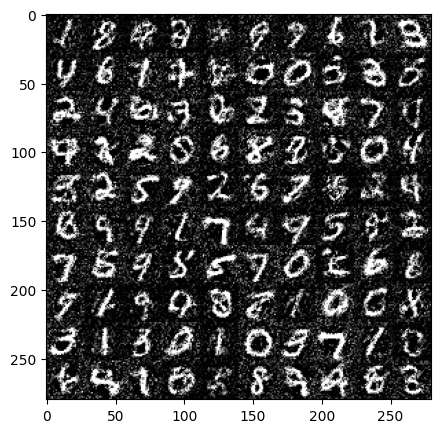

In [ ]:

grid = make_grid(
    traj[-1, :].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.figure(figsize = (5,5))
plt.imshow(img)

### The generated images change gradually.

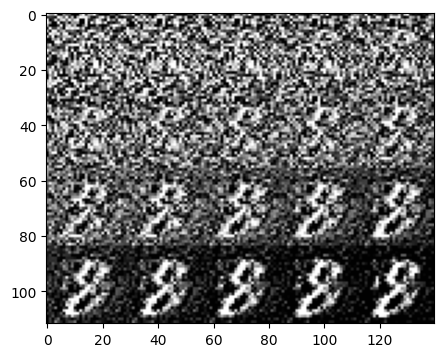

In [ ]:
grid = make_grid(
    traj[:, 1].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=5
)
img = ToPILImage()(grid)
plt.figure(figsize = (5,5))
plt.imshow(img)

## TorchCFM: An awesome implementation on Github
https://github.com/atong01/conditional-flow-matching